#  Proyecto Final  

Autores:

   * Pablo Izquierdo Conde
   * Jorge Pose Eiroa

Fecha: 26-12-2018

# 1. Obtención de categorías

La primera parte del Proyecto consiste en obtener las páginas con las que vamos a trabajar. Para ello seleccionamos dos categorías de la Wikipedia, que en nuestro caso, y por ser las categorías iniciales muy disjuntas, el profesor nos ha permitido escoger dos subcategorías de la categoría `Sports`.

In [1]:
import wikipediaapi as wk
import numpy as np
import copy

wiki = wk.Wikipedia('en')

# Cogemos las categorías seleccionadas
cat0 = wiki.page("Category:Esports")
cat1 = wiki.page("Category:Combat_sports")

Una vez seleccionadas las categorías es necesario obtener las páginas que cuelgan de ellas, así como algunas de las páginas que cuelgan de las subcategorías de las categorías elegidas. Esto es lo que hace la siguiente función, a la que le hemos puesto una profundidad de 3 niveles, que es más que suficiente para obtener el número de páginas necesarias.

In [2]:
# Función que busca recursivamente en las categorías y nos devuelve una lista con las páginas
def print_categorymembers(categorymembers, level=0, max_level=2, pages = []):
    for c in categorymembers.values():
        if c.ns == 0: # Sacamos las páginas (ns=0)
            pages.append(c)
        if c.ns == wk.Namespace.CATEGORY and level <= max_level:
            print_categorymembers(c.categorymembers, level + 1,1, pages)
p0 = [] #len=1227
p1 = []#len=4288
print_categorymembers(cat0.categorymembers,0,1, p0)
print_categorymembers(cat1.categorymembers,0,1, p1)

Una vez obtenidas las páginas, procedemos a obtener el texto que usaremos como corpus para el resto del proyecto, tomando 500 páginas aleatorias de cada categoría. Este proceso va a llevar un rato, ya que es necesario recorrer todas las páginas y descargar el texto.

Para poder elegir las páginas de forma aleatoria, se va a realizar una permutación aleatoria sobre los índices de las páginas, para posteriormente coger las 500 primeras como datos de entrenamiento y las 200 siguientes como datos de test.

In [3]:
indices0 = np.random.permutation(len(p0))
indices1 = np.random.permutation(len(p1))

indices0_train = indices0[:500]
indices1_train = indices1[:500]

# Sacamos el texto de las listas de páginas
corpus0 = []
corpus1 = []

# Corpus 0 train
print('Corpus 0')
for n,i in enumerate(indices0_train):
    if not n%100:
        print('\rPage', n, 'out of', len(indices0_train), end='', flush=True)
    corpus0.append(p0[i].text)
     
# Corpus 1 train    
print('\nCorpus 1')
for n,i in enumerate(indices1_train):
    if not n%100:
        print('\rPage', n, 'out of', len(indices1_train), end='', flush=True)
    corpus1.append(p1[i].text)

corpustotal=copy.deepcopy(corpus0) # Copiamos el corpus0 en el corpustotal
corpustotal.extend(corpus1) # Lo mismo con el corpus1

Corpus 0
Page 400 out of 500
Corpus 1
Page 400 out of 500

Al usar el método `text` sobre las distintas páginas obtenemos directamente el contenido del artículo en texto plano, y además se elimina la sección de `Categories` y otras que pudieran interferir con los restultados, como `References`.

Puede comprobarse que esto es así imprimiendo cualquier página de las guardadas en `corpustotal`.

In [4]:
print(corpustotal[921])

A folk wrestling style is any traditional  style of wrestling, which may or may not be codified as a modern sport. Most cultures have developed regional forms of grappling.

Europe
British Isles
Traditionally wrestling has two main centers in Great Britain: the West Country, where the Devon and Cornwall styles were developed, and in the Northern counties, the home of the Cumberland and Westmorland styles.

North Country styles
Lancashire wrestling is a historic wrestling style from Lancashire in England known for its "Catch-as-catch-can", or no wrestling holds barred, style.
Catch wrestling, or Catch-as-catch-can, originated from Lancashire wrestling but was further developed during the traveling circus phenomenon of the 19th and early 20th century United States.
Backhold Wrestling, whose origin is unknown, was practiced in North England and Scotland in the 7th and 8th century but competitions are held in present-day at the Highland and Border Games as well as in France and Italy. Styl

# 2. Procesado de texto

Para la parte de procesador de texto se va a usar NLTK y van a seguirse los siguientes pasos:
    1. Tokenization
    2. Homogeneization
    3. Cleaning
    4. Vectorization
    
Una vez terminado este proceso, se obtendrá la `Bag-of-Words` correspondiente al `corpus`, que se introducirá en modelo LDA

In [5]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim

wnl = WordNetLemmatizer()
stopwords_en = stopwords.words('english')
palabros = ['wa','also','ha'] # Después de ver los resultados hemos añadido más palabras a las stopwords
stopwords_en.extend(palabros)

C:\Users\pablo\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [6]:
# Esta función va a limpiarnos el corpus realizando la tokenización, la lemmatización y la eliminación de stopwords
def getCorpusClean(corpus):
    corpus_clean=[]
    for text in corpus:
        tokens = word_tokenize(text)
        tokens_filtered = [el.lower() for el in tokens if el.isalnum() and not el.isdigit()] # Nos quedamos solo con palabras, quitamos numeros
        tk_lemmat = [wnl.lemmatize(el) for el in tokens_filtered]
        tk_clean = [tk for tk in tk_lemmat if tk not in stopwords_en]
        corpus_clean.append(tk_clean)
    return corpus_clean

corpus_clean = getCorpusClean(corpustotal)

In [7]:
# Con esta función obtenemos la Bag-of-Words a partir del corpus limpio
def getCorpusBow(corpus_clean, no_below = 5, no_above = .75):
    D = gensim.corpora.Dictionary(corpus_clean)
    D.filter_extremes(no_below=no_below, no_above=no_above, keep_n=25000)
    corpus_bow = [D.doc2bow(doc) for doc in corpus_clean]
    return corpus_bow, D
    
corpus_bow, D = getCorpusBow(corpus_clean)

# 3. Modelado de tópicos con LDA

El modelado de tópicos se realiza teniendo en cuenta los documentos de ambas categorías, para generar así tópicos que permitan distinguir documentos pertenecientes a una y a otra.

In [8]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel

# Función que nos genera el modelo LDA a partir de la BOW y el número de tópicos
def getLDAModel(corpus_bow, D, num_topics):
    ldag = gensim.models.ldamodel.LdaModel(corpus=corpus_bow, id2word=D, num_topics = num_topics, passes=20)
    return ldag

num_topics = 50
ldag = getLDAModel(corpus_bow, D, num_topics)

Para la elección del número de tópicos se ha realizado un análisis del efecto que esto tiene en la coherencia de los tópicos:

In [9]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=ldag, texts=corpus_clean, dictionary=D, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.47626157222307247


In [10]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

A continuación se va a calcular el número de tópicos óptimo en función de la coherencia. Esto puede tardar un rato.

In [11]:
# Show graph
import matplotlib.pyplot as plt
limit=70; start=10; step=6;
model_list, coherence_values = compute_coherence_values(dictionary=D, corpus=corpus_bow, texts=corpus_clean, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

<Figure size 640x480 with 1 Axes>

A partir de la gráfica nos quedamos con el modelo que tiene el número de tópicos con el valor de coherencia más alto

In [13]:
ldag=model_list[np.argmax(coherence_values)]

Para visualizar de una manera más clara los tópicos se traza el siguiente gráfico. En este se observa como los tópicos que sobresalen en la misma categoría se encuentran más próximos, y la influencia de cada término en los distintos tópicos (y por ende en las categorías).

In [14]:
def visTopics(ldag, corpus_bow, D):    
    vis_data = gensimvis.prepare(ldag, corpus_bow, D, sort_topics=False)
    return pyLDAvis.display(vis_data)   

visTopics(ldag, corpus_bow, D)

C:\Users\pablo\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


La presentación escrita de las palabras más relevantes de cada tópico se muestra a continuación:

In [15]:
for i in range(0, ldag.num_topics):
    temp = ldag.show_topic(i, 10)
    terms = []
    for term in temp:
        terms.append(term)
    print("Top 10 terms for topic #" + str(i+1) + ": " + ", ".join([i[0] for i in terms]))
    if i==0:
        terms0=terms

Top 10 terms for topic #1: world, championship, season, final, global, korea, warcraft, starcraft, challenge, ii
Top 10 terms for topic #2: game, tekken, character, halo, version, player, new, jin, fighting, heihachi
Top 10 terms for topic #3: chess, boxing, first, fight, london, world, de, one, round, time
Top 10 terms for topic #4: wrestling, style, taekwondo, art, martial, sport, federation, competition, international, technique
Top 10 terms for topic #5: team, player, game, match, map, one, two, group, round, qualifier
Top 10 terms for topic #6: 1st, major, eleague, season, esl, 2nd, final, c, faze, clan
Top 10 terms for topic #7: party, lan, killer, instinct, computer, game, one, character, xrd, often
Top 10 terms for topic #8: team, league, season, tournament, esports, player, championship, final, roster, first
Top 10 terms for topic #9: fighter, boxing, mma, kg, fight, champion, glove, mixed, martial, division
Top 10 terms for topic #10: game, held, pax, event, first, nba, conve

El siguiente paso es obtener la matriz de entrenamiento que va a introducirse en el clasificador. Para ello tenemos que transformar la matriz dispersa que obtenemos del modelo en una matriz completa.

In [23]:
# Esta función nos devuelve la matriz extendida a partir de la matriz dispersa que nos da el modelo
def getExpandedMatrix(corpus_bow, ldag, num_topics):
        reduced_corpus = [el for el in ldag[corpus_bow[:]]]
        X = gensim.matutils.corpus2dense(reduced_corpus, num_topics).T
        return X


Xtotal = getExpandedMatrix(corpus_bow, ldag, ldag.num_topics)

# También generamos el vector de etiquetas 
y0 = np.zeros((500,1)) #antes 1000
y1 = np.ones((500,1)) #antes 1000
Stotal = np.vstack((y0,y1))

In [24]:
print(Xtotal.shape)

(1000, 34)


# 4. Implementación del clasificador

Una vez obtenida la matriz de entrenamiento, se procede a entrenar un clasificador. En nuestro caso hemos utilizado uno de tipo `SVM`con kernel `rbf`. 

In [25]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
import sklearn.model_selection as modselect
from sklearn.metrics import mean_squared_error, accuracy_score

X_tr, X_test, S_tr, S_test = modselect.train_test_split(Xtotal, Stotal, test_size=0.20, random_state=42)

Preparamos los parámetros para la validación cruzada

In [26]:
svcparams = {'C': [100, 200, 350, 500, 1000, 1200, 1500 ],
     'gamma': [0.3, 0.5, 0.7, 0.9, 1.1]}

clf = svm.SVC(kernel = 'rbf')
svcGrid = modselect.GridSearchCV(clf, svcparams, cv=20, verbose=1, scoring='accuracy', n_jobs=-2).fit(Xtotal,np.ravel(Stotal))

Fitting 20 folds for each of 35 candidates, totalling 700 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done 587 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-2)]: Done 700 out of 700 | elapsed:    7.8s finished


In [27]:
print('best accuracy score', svcGrid.best_score_)
print('best_params', svcGrid.best_params_)

best accuracy score 0.959
best_params {'C': 350, 'gamma': 0.9}


Elegimos la combinación de parámetros que nos de mejor resultado

In [28]:
clf = svcGrid.best_estimator_
clf.fit(X_tr,np.ravel(S_tr))

print('Accuracy: ',accuracy_score(S_test, clf.predict(X_test)))

Accuracy:  0.95


Una vez hecho el clasificador, obtenemos un conjunto de test de 200 artículos por categoría

In [29]:
# Obtenemos los índices de las páginas de test

indices0_test = indices0[500:700] 
indices1_test = indices1[500:700]

# Sacamos el texto de las listas de páginas
corpus0 = []
corpus1 = []

# Corpus 0 test
print('Corpus 0')
for n,i in enumerate(indices0_test):
    if not n%100:
        print('\rPage', n, 'out of', len(indices0_test), end='', flush=True)
    corpus0.append(p0[i].text)
     
# Corpus 1 test  
print('\nCorpus 1')
for n,i in enumerate(indices1_test):
    if not n%100:
        print('\rPage', n, 'out of', len(indices1_test), end='', flush=True)
    corpus1.append(p1[i].text)

corpusTest=copy.deepcopy(corpus0)
corpusTest.extend(corpus1)

Corpus 0
Page 100 out of 200
Corpus 1
Page 100 out of 200

In [30]:
print(len(corpusTest))

400


Una vez obtenido el corpus de test, lo limpiamos y obtenemos la `BOW` utilizando el diccionario que hemos obtenido en el conjunto de entrenamiento. Por último, obtenemos la matriz de test con el modelo de LDA entrenado antes

In [34]:
corpus_test_clean = getCorpusClean(corpusTest)
corpus_test_bow = [D.doc2bow(doc) for doc in corpus_test_clean]

# Una vez obtenido el BOW, sacamos la matriz extendida de igual forma que antes
Xtest = getExpandedMatrix(corpus_test_bow, ldag, ldag.num_topics)

# También generamos el vector de etiquetas para comprobar la precisión
y0 = np.zeros((len(indices0_test),1))
y1 = np.ones((len(indices1_test),1))
Stest = np.vstack((y0,y1))

In [32]:
print(Xtest.shape)

(400, 34)


Para terminar probamos el clasificador con los datos de test

In [35]:
clf.fit(Xtotal, np.ravel(Stotal))
print('Accuracy: ',accuracy_score(Stest, clf.predict(Xtest)))

Accuracy:  0.9425


# 5. Expansión

En nuestro caso hemos elegido como ampliación del proyecto utilizar diversos métodos de visualización de los tópicos, diferentes a los vistos en clase.
Hemos elegido utlizar `WordCloud`, el algoritmo `PCA` y una visualización con grafos que nos permite esbozar las dos categorías utilizadas.

En primer lugar utilizamos `WordCloud` para visualizar las palabras más importantes de alguno de los tópicos.

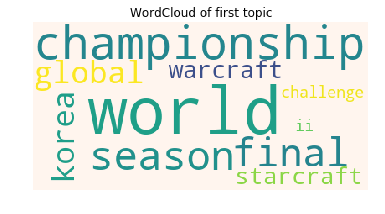

In [19]:
from os import path
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def terms_to_wordcounts(terms, multiplier=1000):
    return  " ".join([" ".join(int(multiplier*i[1]) * [i[0]]) for i in terms])

wordcloud = WordCloud(collocations=False, background_color='seashell').generate(terms_to_wordcounts(terms0))

plt.imshow(wordcloud)
plt.title("WordCloud of first topic")
plt.axis("off")
plt.savefig("terms1")

#plt.close()

A continuación, en lugar de utilizar LDA utilizaremos PCA como método para reducción de dimensiones. La principal diferencia es que PCA
es no supervisado, ignorando la clasificación (class labels)

In [20]:
## topic-words vectors: topics vs. words
from sklearn.feature_extraction import DictVectorizer

def topics_to_vectorspace(n_topics, n_words=100):
    rows = []
    for i in range(n_topics):
        temp = ldag.show_topic(i, n_words)
        row = dict(((i[0],i[1]) for i in temp))
        rows.append(row)

    return rows    

vec = DictVectorizer()

X = vec.fit_transform(topics_to_vectorspace(ldag.num_topics))
#X.shape

Utilizando la herramienta de sklearn para implementar PCA y mostrar el resultado en dos dimensiones obtenemos una representación similar de los
tópicos que la que obtuvimos anteriormente con LDA. También podemos mostrar una representación de las palabras

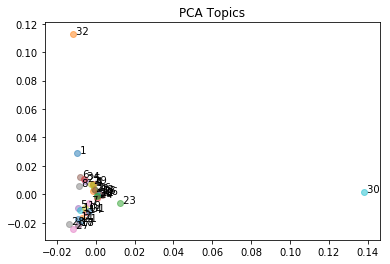

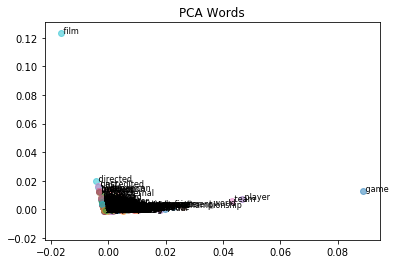

In [21]:
## PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit(X.toarray()).transform(X.toarray())

plt.figure()
for i in range(X_pca.shape[0]):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], alpha=.5)
    plt.text(X_pca[i, 0], X_pca[i, 1], s=' ' + str(i+1))    

plt.title('PCA Topics')
plt.savefig("pca_topic")

X_pca = pca.fit(X.T.toarray()).transform(X.T.toarray())

plt.figure()
for i, n in enumerate(vec.get_feature_names()):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], alpha=.5)
    plt.text(X_pca[i, 0], X_pca[i, 1], s=' ' + n, fontsize=8)

plt.title('PCA Words')
plt.savefig("pca_words")

#plt.close()

Por último, podemos ver un grafo a partir de la reducción dimensional con PCA, mostrando conexiones entre los tópicos más relacionados (que vendrían a mostrar un esbozo de las categorías).

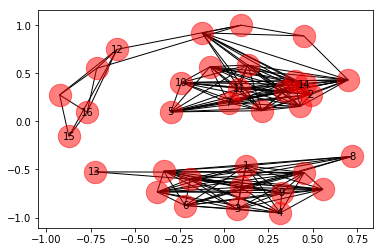

In [22]:
## network
import networkx as nx

from scipy.spatial.distance import pdist, squareform
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

pca_norm = make_pipeline(PCA(n_components=2), Normalizer(copy=False))

X_pca_norm = pca_norm.fit(X.toarray()).transform(X.toarray())

cor = squareform(pdist(X_pca_norm, metric="euclidean"))

G = nx.Graph()

for i in range(cor.shape[0]):
    for j in range(cor.shape[1]):
        if i == j:
            G.add_edge(i, j, weight=0)
        else:
            G.add_edge(i, j, weight=1.0/cor[i,j])

edges = [(i, j) for i, j, w in G.edges(data=True) if w['weight'] > 1.5]
edge_weight=dict([((u,v,),int(d['weight'])) for u,v,d in G.edges(data=True)])

#pos = nx.graphviz_layout(G, prog="twopi") # twopi, neato, circo
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=500, alpha=.5)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=1)
#nx.draw_networkx_edge_labels(G, pos ,edge_labels=edge_weight)
labels = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5 : 6, 6 : 7, 7 : 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16}
nx.draw_networkx_labels(G, pos, labels=labels,font_size=10, font_family='sans-serif')
plt.savefig("network")

#plt.close()

Una vez hallados los tópicos (utilizaremos LDA a partir de aquí nuevamente, como estaba previsto en la tarea original), es necesario pasarlos a una matriz para poder ser utilizados por el clasificador.